Analyzing ADWIN Data

In [3]:
import random
from river import drift
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
file_time_a = '../Time Development/Data/time_a.csv'
file_time_b_decay = '../Time Development/Data/time_b_decay.csv'
file_time_b_normal = '../Time Development/Data/time_b_normal.csv'
file_time_b_growth = '../Time Development/Data/time_b_growth.csv'

time_a_df = pd.read_csv(file_time_a)
time_b_decay_df = pd.read_csv(file_time_b_decay)
time_b_normal_df = pd.read_csv(file_time_b_normal)
time_b_growth_df = pd.read_csv(file_time_b_growth)

In [5]:
time_a_df.drop(columns=['Unnamed: 0'],inplace=True)
time_b_decay_df.drop(columns=['Unnamed: 0'],inplace=True)
time_a_df['Date'] = pd.to_datetime(time_a_df['Date'], format='%Y-%m-%d')
time_b_decay_df['Date'] = pd.to_datetime(time_b_decay_df['Date'], format='%Y-%m-%d')

In [24]:
date = np.unique(time_a_df['Date']).astype('datetime64[D]')

engagement = time_a_df['Engagement']
ctr = time_a_df['CTR']
all_data_decay = pd.concat([time_a_df,time_b_decay_df],axis=0)


all_ctr = all_data_decay['CTR']
all_engagement = all_data_decay['Engagement']

avg_ctr = all_data_decay.groupby('Date')['CTR'].mean()
avg_engagement = all_data_decay.groupby('Date')['Engagement'].mean()

#Launch date for the product
product_launch_date = np.max(np.unique(time_a_df['Date']).astype('datetime64[D]'))

In [25]:
def delay_calculator(product_launch_date, change_points):
    earliest_detection = min([val[0] for val in change_points])
    delay = earliest_detection - product_launch_date
    return delay

In [26]:
delta_range = [.25, .15, .05, .02, .01, .005, .002, .001]
min_window_length_range = [1,2,5,10,15,20]


adwin = drift.ADWIN(delta = .05, # significance value
                    clock=1, # how often ADWIN should check for changes
                    min_window_length=5, #Min length allowerd when checking concept drift, smaller may decrease delay but lead to false positives
                    grace_period=0) #when to start looking




df = all_data_decay
target_column = 'Engagement'
all_dates = np.unique(all_data_decay['Date']).astype('datetime64[D]')

def adwin_tests(adwin_model, df, target_column):
    avg_target = df.groupby('Date')[target_column].mean()
    median_target = df.groupby('Date')[target_column].median()
    all_dates = np.unique(df['Date']).astype('datetime64[D]')

    
    change_points_avg = []
    for date, val in avg_target.items():
        adwin_model.update(val)
        if adwin_model.drift_detected:
            print(f"Change detected at {date}, input value: {val}")
            change_points_avg.append((date,val))

    change_points_median = []
    for date, val in median_target.items():
        adwin_model.update(val)
        if adwin_model.drift_detected:
            print(f"Change detected at {date}, input value: {val}")
            change_points_median.append((date,val))


    plt.figure(figsize=(12, 6))
    sns.lineplot(x=avg_target.index, y=avg_target, label=f"{target_column} (Average)")
    sns.lineplot(x=avg_target.index, y=median_target, label=f"{target_column} (Median)")
    plt.axvline(x=time_a_df["Date"].iloc[-1], color="red", linestyle="--", label="Product Launch (Time B Start)")

    for date, val in change_points_avg:
        plt.annotate(
            f"Change detected\n(index {date})", 
            xy=(date, val), 
            #xytext=(date + 10, val + 5),
            arrowprops=dict(arrowstyle="->", lw=1.5),
            fontsize=9,
            backgroundcolor='white'
        )

    for date, val in change_points_median:
        plt.annotate(
            f"Change detected\n(index {date})", 
            xy=(date, val), 
            #xytext=(date + 10, val + 5),
            arrowprops=dict(arrowstyle="->", lw=1.5),
            fontsize=9,
            backgroundcolor='white'
        )    

    plt.xlabel("Date")
    plt.ylabel(target_column)
    plt.title("Data Stream with Change Detection Points")
    plt.legend()
    plt.show()

    # delay_avg = delay_calculator(time_a_df.index[-1], change_points_avg)
    # delay_median = delay_calculator(time_a_df.index[-1], change_points_median)

    return change_points_avg, change_points_median #,delay_avg, delay_median


Change detected at 2024-09-14 00:00:00, input value: 54.48396844191395
Change detected at 2024-12-18 00:00:00, input value: 54.07574378996169
Change detected at 2024-01-14 00:00:00, input value: 48.88398864706524
Change detected at 2024-10-17 00:00:00, input value: 49.57372447980182


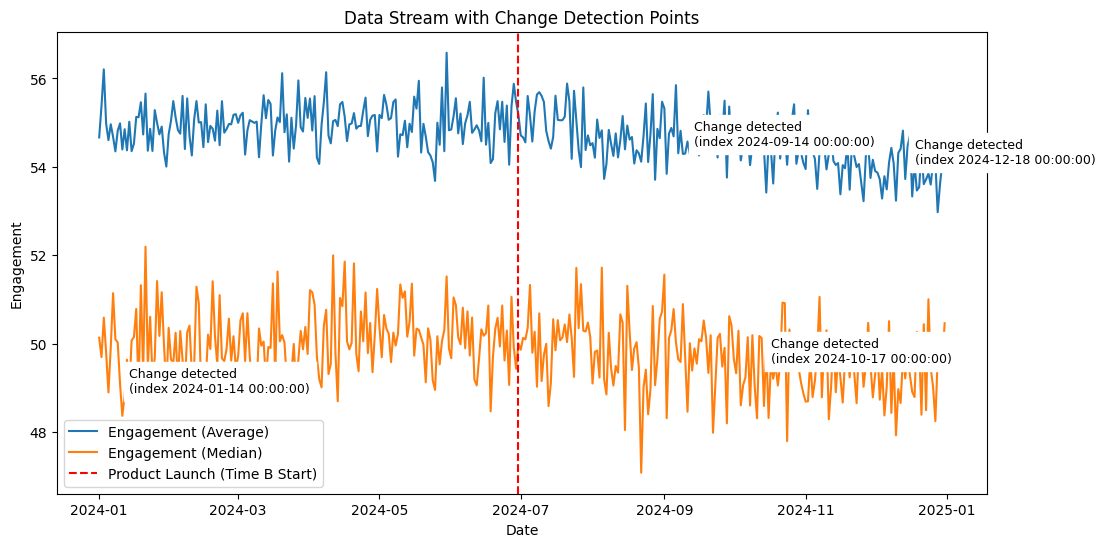

In [27]:
change_points_avg, change_points_median = adwin_tests(adwin, all_data_decay, 'Engagement')

<Axes: ylabel='Engagement'>

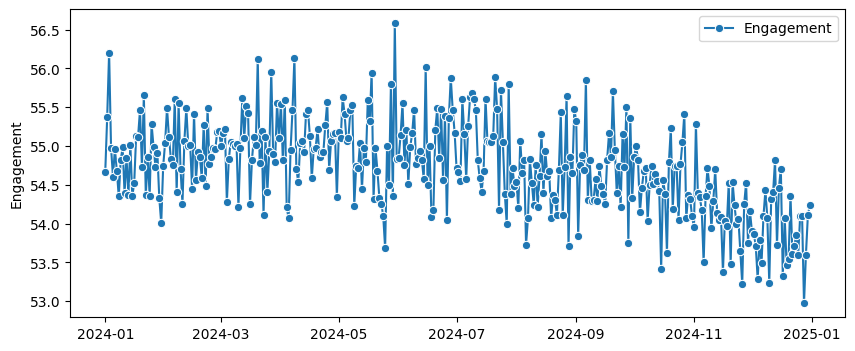

In [19]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=all_dates, y=avg_engagement, marker="o", label="Engagement")

Change detected at index 288, input value: 48.402587548652285
1


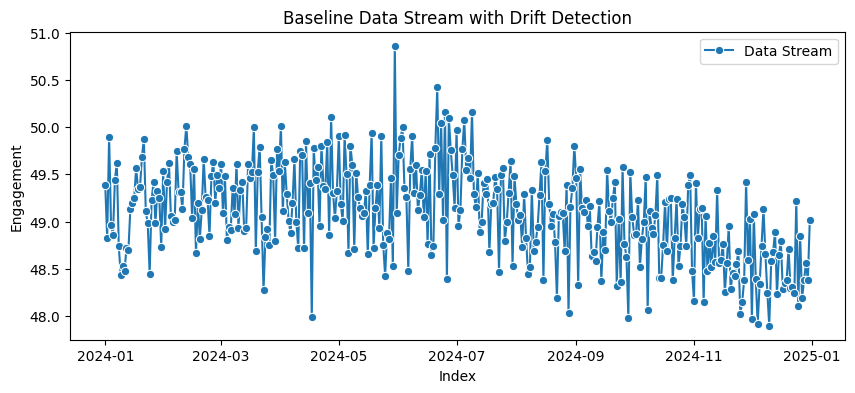

Change detected at index 314, input value: 38.18465455200966
1


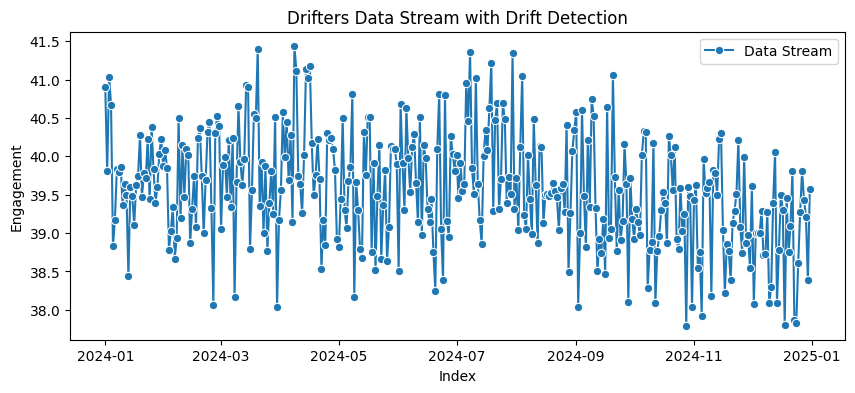

Change detected at index 330, input value: 84.32861766447058
1


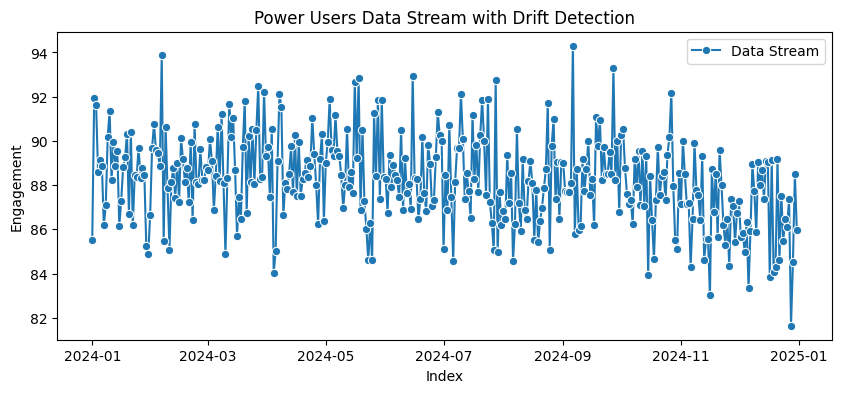

In [ ]:
#Look how well it works against different groups
user_groups = {user_id: group for user_id, group in all_data_decay.groupby('Group')}


for group_name, group in user_groups.items():

    avg_engagement = group.groupby('Date')['Engagement'].mean()
    group_dates = avg_engagement.index



    #WANT TO ADJUST THIS ADWIN
    adwin_by_group = drift.ADWIN(delta = .01,
                    clock=1,
                    min_window_length=1,
                    grace_period=5) # Create a new ADWIN instance for this user
    
    change_points = [] 

    data_stream = list(avg_engagement)

    change_points = []
    for i, val in enumerate(data_stream):
        adwin_by_group.update(val)
        if adwin_by_group.drift_detected:
            print(f"Change detected at index {i}, input value: {val}")
            print(adwin_by_group.n_detections)
            change_points.append((i,val))


    plt.figure(figsize=(10, 4))
    sns.lineplot(x=group_dates, y=avg_engagement, marker="o", label="Data Stream")


    for idx, val in change_points:
        plt.annotate(
            f"Change at {idx}", 
            xy=(idx, val), 
            xytext=(idx, val + 1),
            arrowprops=dict(arrowstyle="->", lw=1.5),
            fontsize=9
        )

    plt.title(f"{group_name} Data Stream with Drift Detection")
    plt.xlabel("Index")
    plt.ylabel("Engagement")
    plt.legend()
    plt.show()